In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, train_test_split, LeaveOneOut, KFold
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from scipy.stats import ttest_rel

from numpy import logspace, random, isnan
import pickle
from scipy.stats import rankdata
from os.path import basename

from json import dumps 

import shap
from copy import deepcopy

from sklearn.ensemble import RandomForestRegressor
import TraitData
from imp import reload
import seaborn as sns
reload(TraitData)
sns.set()
sns.set(font_scale=1.5)

cv = KFold(n_splits=10)

# try:
#     SAVED_STATE = pickle.load(open("np.random.state", 'rb'))
#     np.random.set_state(SAVED_STATE)
# except Exception as e:
#     SAVED_STATE = False
    

%matplotlib inline
plt.rcParams['figure.figsize'] = (7,15)
%config InlineBackend.figure_format = 'retina'

<img style="float:right" src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" width=60px)/>
<h1> Feature Interpretation Across Methods: A Study. <small> by: Tony Cannistra </small></h1>
We are attempting to understand the type and magnitude of the effects that various physiological or behavioral traits have had on historical range shifts.

The challenge is that standard linear regression has been only able to explain a small percentage of the variance seen in range shift data for several taxa ([Angert et al., 2011](http://onlinelibrary.wiley.com/doi/10.1111/j.1461-0248.2011.01620.x/abstract)). This is likely as a result of the relationships between predictor and response variables being something other than linear, especially since several variables have biological relevance for their ability to facilitate range shifts. 

## Load Data + Define Functions
For this exploration we have trait data for several large taxonomic groups of organisms and their observed range shifts over the past 100 years. There are 3 datasets
### Define Each Dataset

In [2]:
plantsData = {
    'name' : "Alpine Plants",
    'file' : "../data/angert_etal_2011/plants5.csv",
    
    'responseVar'   : "migration_m",

    'drop_features' : ["Taxon",
                     "migr_sterr_m", 
                     "shift + 2SE", 
                     'signif_shift',
                     "signif_shift2",
                     "dispmode01",
                     "DispModeEng", ## what is this
                     "shift + 2SE", 
                      "Grime"],
    'categorical_features' : ["oceanity",
                            "dispersal_mode",
                            "BreedSysCode", "SI01"], 
    
    'traits_desc_file' : "../data/angert_etal_2011/traits-desc-plants.csv"
}

plantsData_extendedDrop = deepcopy(plantsData)
plantsData_extendedDrop['name'] = "Alpine Plants-extendeddrop"
plantsData_extendedDrop.get('drop_features').extend(["Bio1_mean_nosyn",
                                                 "Bio1_std_nosyn",
                                                 "Bio1_var_nosyn", 
                                                 "Bio1_mean_inclsyn",
                                                 "Bio1_std_inclsyn",
                                                 "Bio1_var_inclsyn"])

mammalData = {
    'name' : "Mammals",
    'file' : "../data/angert_etal_2011/mammals01.csv",
    
    'responseVar'   : "High_change",

    'drop_features' : ["Taxon",
                       "High_change_pfa2",
                       "Daily_rhythm_code",
                       "Annual_rhythm_code"],
    
    'categorical_features' : ["Daily01",
                              "Annual01",
                              "Food01",
                              "Daily_rhythm",
                              "Annual_rhythm",
                              "Food"],
    
    'traits_desc_file' : "../data/angert_etal_2011/traits-desc-mammals.csv"
}

mammalData_extendedDrop = deepcopy(mammalData)
mammalData_extendedDrop['name'] = "Mammals-extendeddrop"
mammalData_extendedDrop.get("drop_features").extend(["Bio1_mean",
                                                     "Daily01_0",
                                                     "Daily01_1",
                                                     "Annual01_0",
                                                     "Annual01_1",
                                                     "Food01_0",
                                                     "Food01_1"])

triennialMarineData = {
    'name' : "Triennial Marine",
    'file' : "../data/marine/west-coast-triennial _species_generaltraits.csv",
    'responseVar' : "Latitudinal Difference",
    
    'drop_features' : ["Species", "Latitudinal Std",
                      "FamCode", "GenCode"], 
    
    'categorical_features' : [
        "UsedforAquaculture",
        "Electrogenic",
        "DemersPelag",
        "LTypeMaxM", 
        "Fresh", 
        "Brack", 
        "Saltwater"
    ], 
    
    'traits_desc_file' : "../data/marine/traits-desc.csv"
}

triennialMarineData_extendedDrop = deepcopy(triennialMarineData)
triennialMarineData_extendedDrop['name'] = "triennialMarineData-extendeddrop"
triennialMarineData_extendedDrop.get("drop_features").extend(["Electrogenic_Electrosensing only",
                                                              "Electrogenic_electrosensing only",
                                                              "Electrogenic_no special ability",
                                                              "Electrogenic_strongly discharging",
                                                              "Electrogenic_weakly discharging",
                                                              "LTypeMaxM_FL","LTypeMaxM_SL", "LTypeMaxM_TL"])


TRYdata = {
    'name': "TRY-rumpfdata",
    'file': "../data/TRY/rumpf_ShiftsTraitsBuckley_20180418.csv",
    'responseVar' : "LeadingEdge", # there's also "RearEdge" and "Optimum"
    'drop_features' : ['speciesname',
                       'Dispersal',
                       'Persistence', 
                       'RearEdge', 
                       'Optimum'],
    'categorical_features': ['LifeStrategy']
}


datasets = [
    plantsData_extendedDrop,
    mammalData_extendedDrop,
    triennialMarineData_extendedDrop,
    TRYdata
]
with open("DATA_SPECIFICATION.json", 'w') as dsjson:
    dsjson.write(dumps(datasets))

all_mses = {}
rankings = []
MSEs = []
COEFs = []


---
### Select, Load, and Normalize Dataset

In [3]:
dataset = TRYdata
dsname = dataset['name'].replace(" ", "-")

dropNA  = 0

td = TraitData.TraitData(dataset['file'],
                         dataset['responseVar'],
                         dataset['drop_features'],
                         dataset['categorical_features'],
                         dropNA=dropNA, scale=True)
## rename traits
try: 
    traitnames = pd.read_csv(dataset['traits_desc_file']).fillna('')
    traitnames_map = { a:b for a, b in zip(traitnames.name, traitnames.description)}
    td.feature_names = [traitnames_map[trait] if traitnames_map[trait] != '' else trait for trait in td.feature_names]
    td.X.columns = td.feature_names
except: 
    print("No trait description.")
    
print(len(td.X))
display(td.X.head())
td.X = np.array(td.X)
td.Y = np.array(td.Y)

print(td.X.shape)
print("\n".join(td.feature_names))





No trait description.
176


/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


,RelativeAbundance,TemperatureIndicator,NutrientIndicator,TerminalVelocity,RetInFurCattle,RetInFurSheep,GutSurvival,SeedReleaseHeight,LifeSpan,Dominance,NoOfVegOffspings,LifeStrategy_ccc,LifeStrategy_ccs,LifeStrategy_crs,LifeStrategy_css,LifeStrategy_rrs,LifeStrategy_rss,LifeStrategy_sss
0,0.085568,-1.345600,-0.248903,-0.802573,0.042180,0.214986,-0.116467,-0.455842,-0.353318,0.855614,1.042962,0,0,0,1,0,0,0
1,-0.143772,-0.484416,-0.248903,0.156527,-0.088059,0.098920,-0.124887,-0.224803,-0.277252,0.855614,-0.240684,0,0,0,1,0,0,0
2,1.060266,0.376768,-0.248903,0.078552,-0.739253,-0.752230,-0.156462,-0.224803,-0.353318,-1.375320,1.684785,0,0,1,0,0,0,0
3,1.690952,0.376768,2.996060,-1.098880,-0.543895,0.447117,-0.150147,3.645095,-0.429384,1.971080,-0.882507,0,1,0,0,0,0,0
4,0.735366,-0.484416,-0.248903,-0.475075,0.302657,0.911381,-0.097523,-0.398082,0.198161,-0.259853,2.326608,0,0,1,0,0,0,0


(176, 18)
RelativeAbundance
TemperatureIndicator
NutrientIndicator
TerminalVelocity
RetInFurCattle
RetInFurSheep
GutSurvival
SeedReleaseHeight
LifeSpan
Dominance
NoOfVegOffspings
LifeStrategy_ccc
LifeStrategy_ccs
LifeStrategy_crs
LifeStrategy_css
LifeStrategy_rrs
LifeStrategy_rss
LifeStrategy_sss


In [27]:
traitnames.description

0                             Storage Organ Presence
1                                                NaN
2                            Flowering Start (month)
3                              Flowering End (month)
4                        Flowering Duration (months)
5                         Seed Shed Month (earliest)
6                           Seed Shed Month (latest)
7                        Seed Shed Duration (months)
8                             Self Compatibility: No
9                            Self Compatibility: Yes
10                                    Seed Mass (mg)
11                                Diaspore Mass (mg)
12                      Diaspore Minimum Length (mm)
13                      Average Seed Shed Height (m)
14                      Average Diaspore Length (mm)
15                      Minimum Seed Shed Height (m)
16                      Maximum Seed Shed Height (m)
17                      Average Seed Shed Height (M)
18                   Total Number of Floristic

In [6]:
pickle.dump(np.random.get_state(), open('np.random.state', 'wb'), )
X_train, X_test, Y_train, Y_test = train_test_split(td.X, td.Y, train_size=0.60)

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Learning

In [7]:
## Importance Plotting Function
def plot_importance(importances, names, title=None, std=None, ft="", save=None):
    sns.set()
    sns.set(font_scale=1.5)
    plt.rcParams['figure.figsize'] = (7,15)
    f, ax = plt.subplots()
    
    bar_indices = np.arange(len(names))
    bar_width = 0.45
    importances_ind = np.argsort(abs(importances))

    plt.barh(bar_indices,
             importances[importances_ind],
            align='center', color='#4b2e83', xerr=std)
    
    plt.figtext(1, 0, ft, ha='right')
    plt.yticks(bar_indices, np.array(names)[importances_ind])
    plt.title(title)
    plt.tight_layout()
    if(save is not None):
        plt.savefig(save, bbox='tight', dpi=200)
    plt.show()
    
def compute_ranks(importances, absolute=True):
    if absolute:
        sorted_idx =  abs(importances).argsort()[::-1]
    else:
        sorted_idx = importances.argsort()[::-1]
    return(np.arange(len(importances))[sorted_idx.argsort()])

### Linear Models
#### OLS

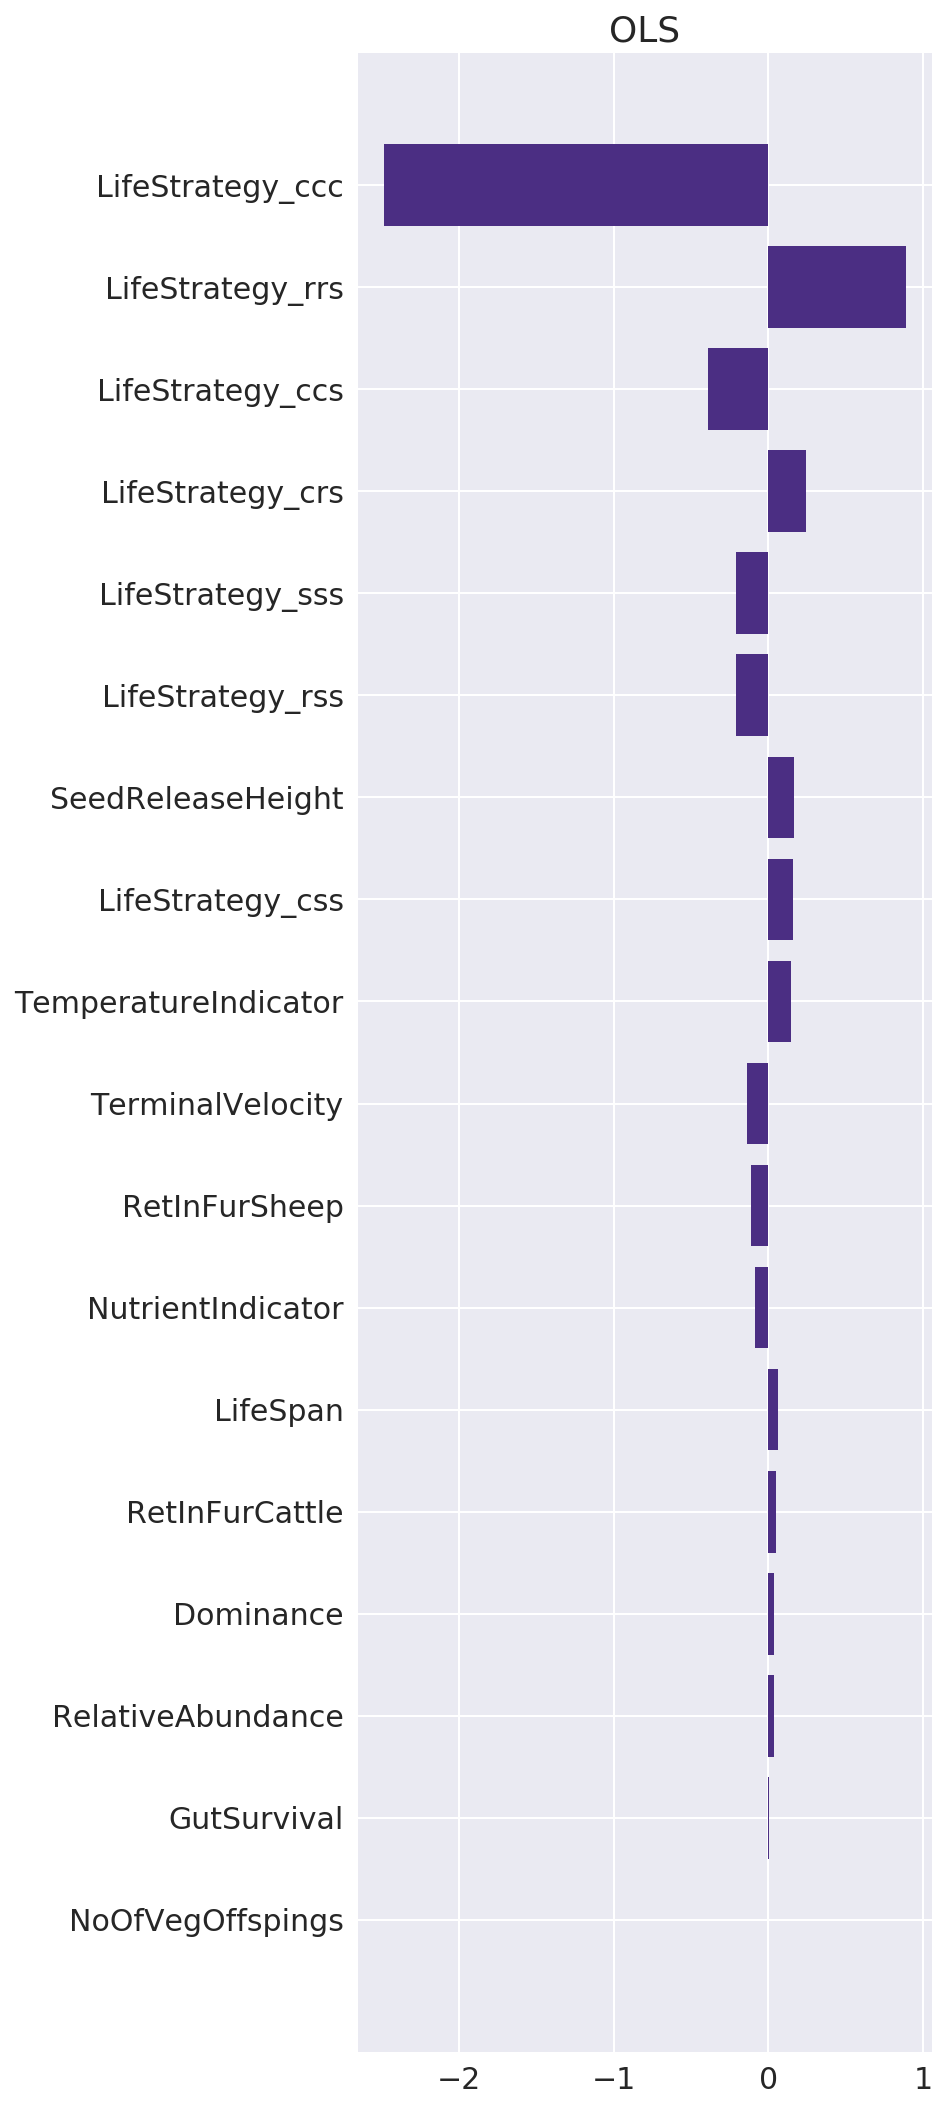

In [8]:
ols_coefs = []
ols_mses = []
for train, test in cv.split(td.X, td.Y):
    ols = LinearRegression(fit_intercept=False, normalize=False)
    ols.fit(td.X[train], td.Y[train])
    preds = ols.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    ols_mses.append(error)
    ols_coefs.append(ols.coef_)
    
mean_error = np.mean(ols_mses)
std_error = np.std(ols_mses)
mean_coefs = np.mean(ols_coefs, axis=0)
std_coefs = np.std(ols_coefs, axis=0)

plot_importance(mean_coefs,
                td.feature_names, "OLS",
                save="{}_ols-ranks.png".format(dsname))#, std=std_coefs)
MSEs.append(("OLS", ols_mses))
COEFs.append(("OLS", mean_coefs))
rankings.append(['OLS'] + list(compute_ranks(mean_coefs)))


#### Ridge CV

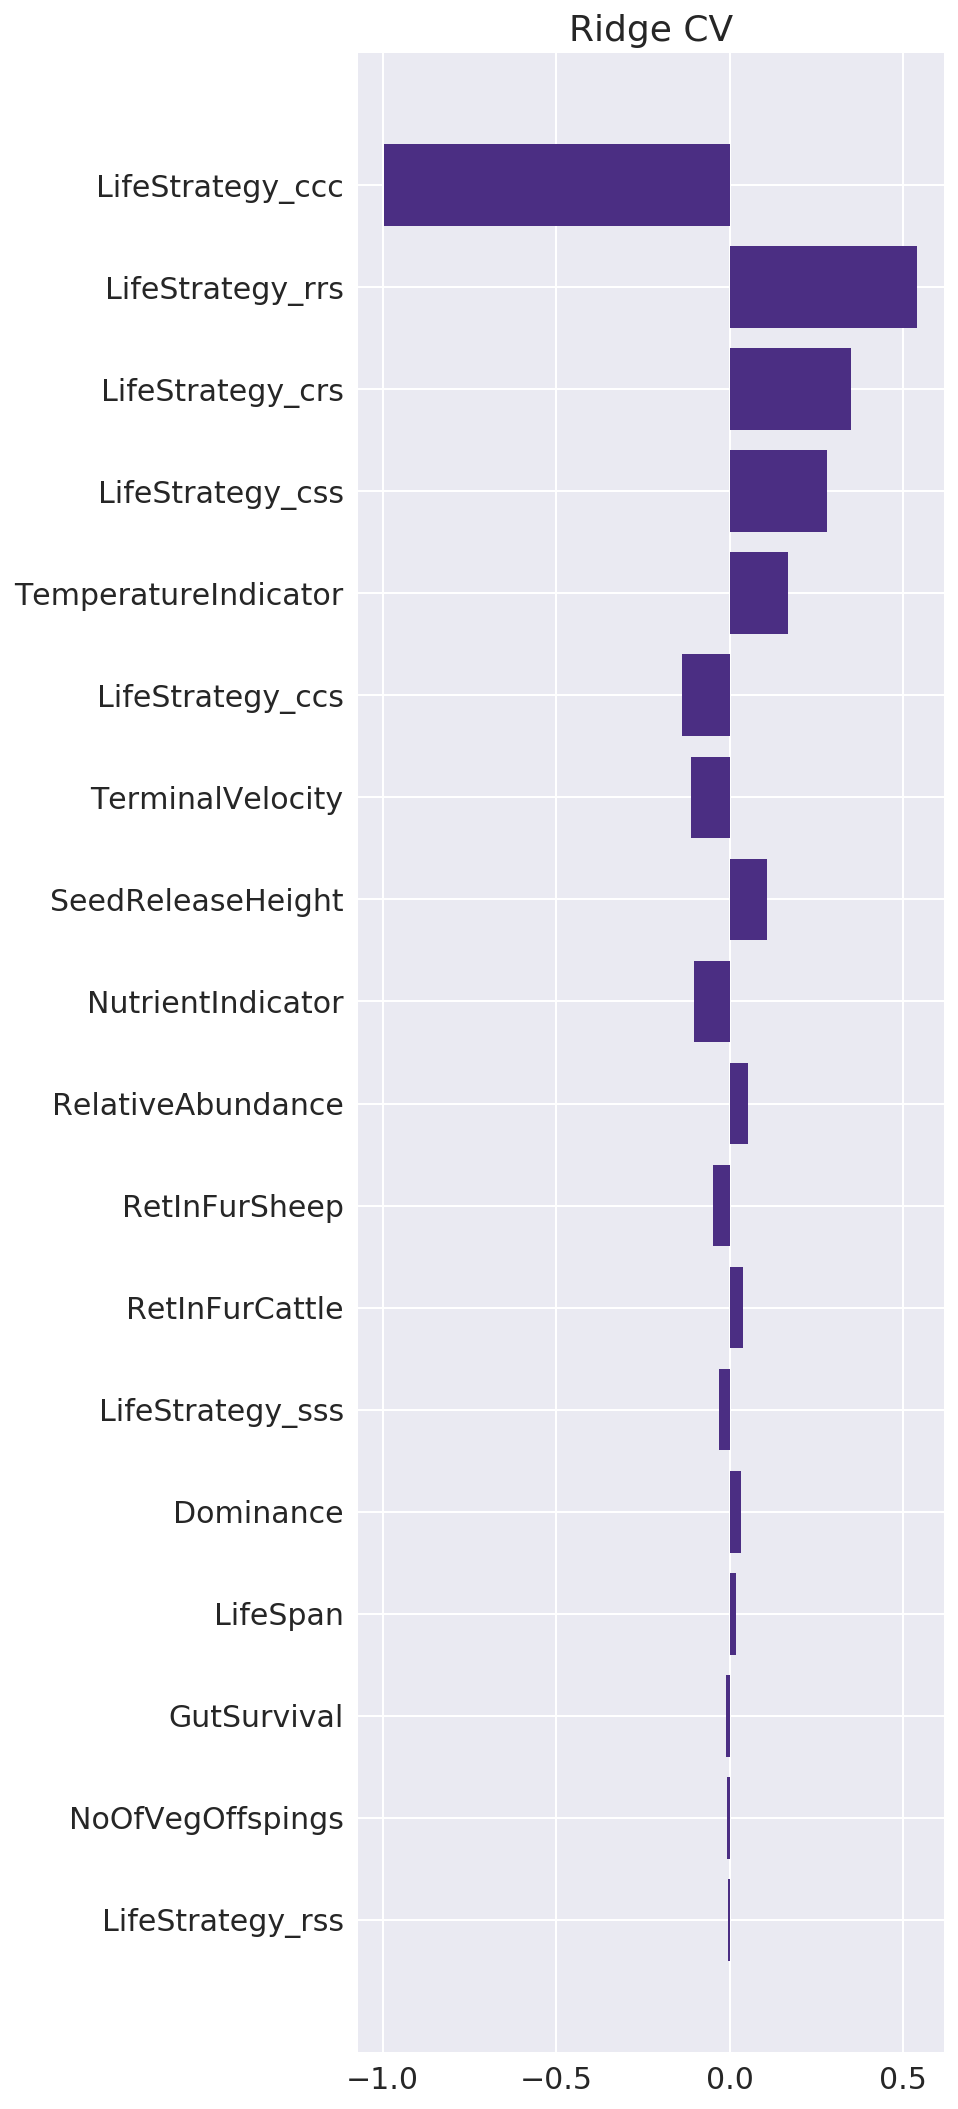

In [9]:
ridge_coefs = []
ridge_mses = []
for train, test in cv.split(td.X, td.Y):
    ridgecv = RidgeCV(normalize=False)
    ridgecv.fit(td.X[train], td.Y[train])
    preds = ridgecv.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    ridge_mses.append(error)
    ridge_coefs.append(ridgecv.coef_)
    
mean_error = np.mean(ridge_mses)
std_error = np.std(ridge_mses)
mean_coefs = np.mean(ridge_coefs, axis=0)
std_coefs = np.std(ridge_coefs, axis=0)

    
plot_importance(mean_coefs, td.feature_names,  "Ridge CV",# std=std_coefs,
               save="{}_ridge-ranks.png".format(dsname))
rankings.append(['Ridge'] + list(compute_ranks(mean_coefs)))
MSEs.append(("Ridge", ridge_mses))
COEFs.append(("Ridge", mean_coefs))


#### Kernel Ridge

In [10]:
kernel_ridge_coefs = []
kernel_ridge_mses = []
for train, test in cv.split(td.X, td.Y):
    kr = KernelRidge(kernel='rbf')
    kr.fit(td.X[train], td.Y[train])
    preds = kr.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    shapdata = shap.DenseData(td.X[train], td.feature_names)
    explainer = shap.KernelExplainer(kr.predict, shapdata, nsamples=100)
    kernel_ridge_coefs.append(explainer.explain(np.mat(td.X[test])).effects)
    kernel_ridge_mses.append(error)
    
#     for i in range(0, len(X_test)-1):
#         try: 
#             explanations.append(explainer.explain(np.mat(td.X[test][i:i+1, :])))
#         except Exception as e:
#             print("error on ", (i, i+1))
#             print(e)
#             continue



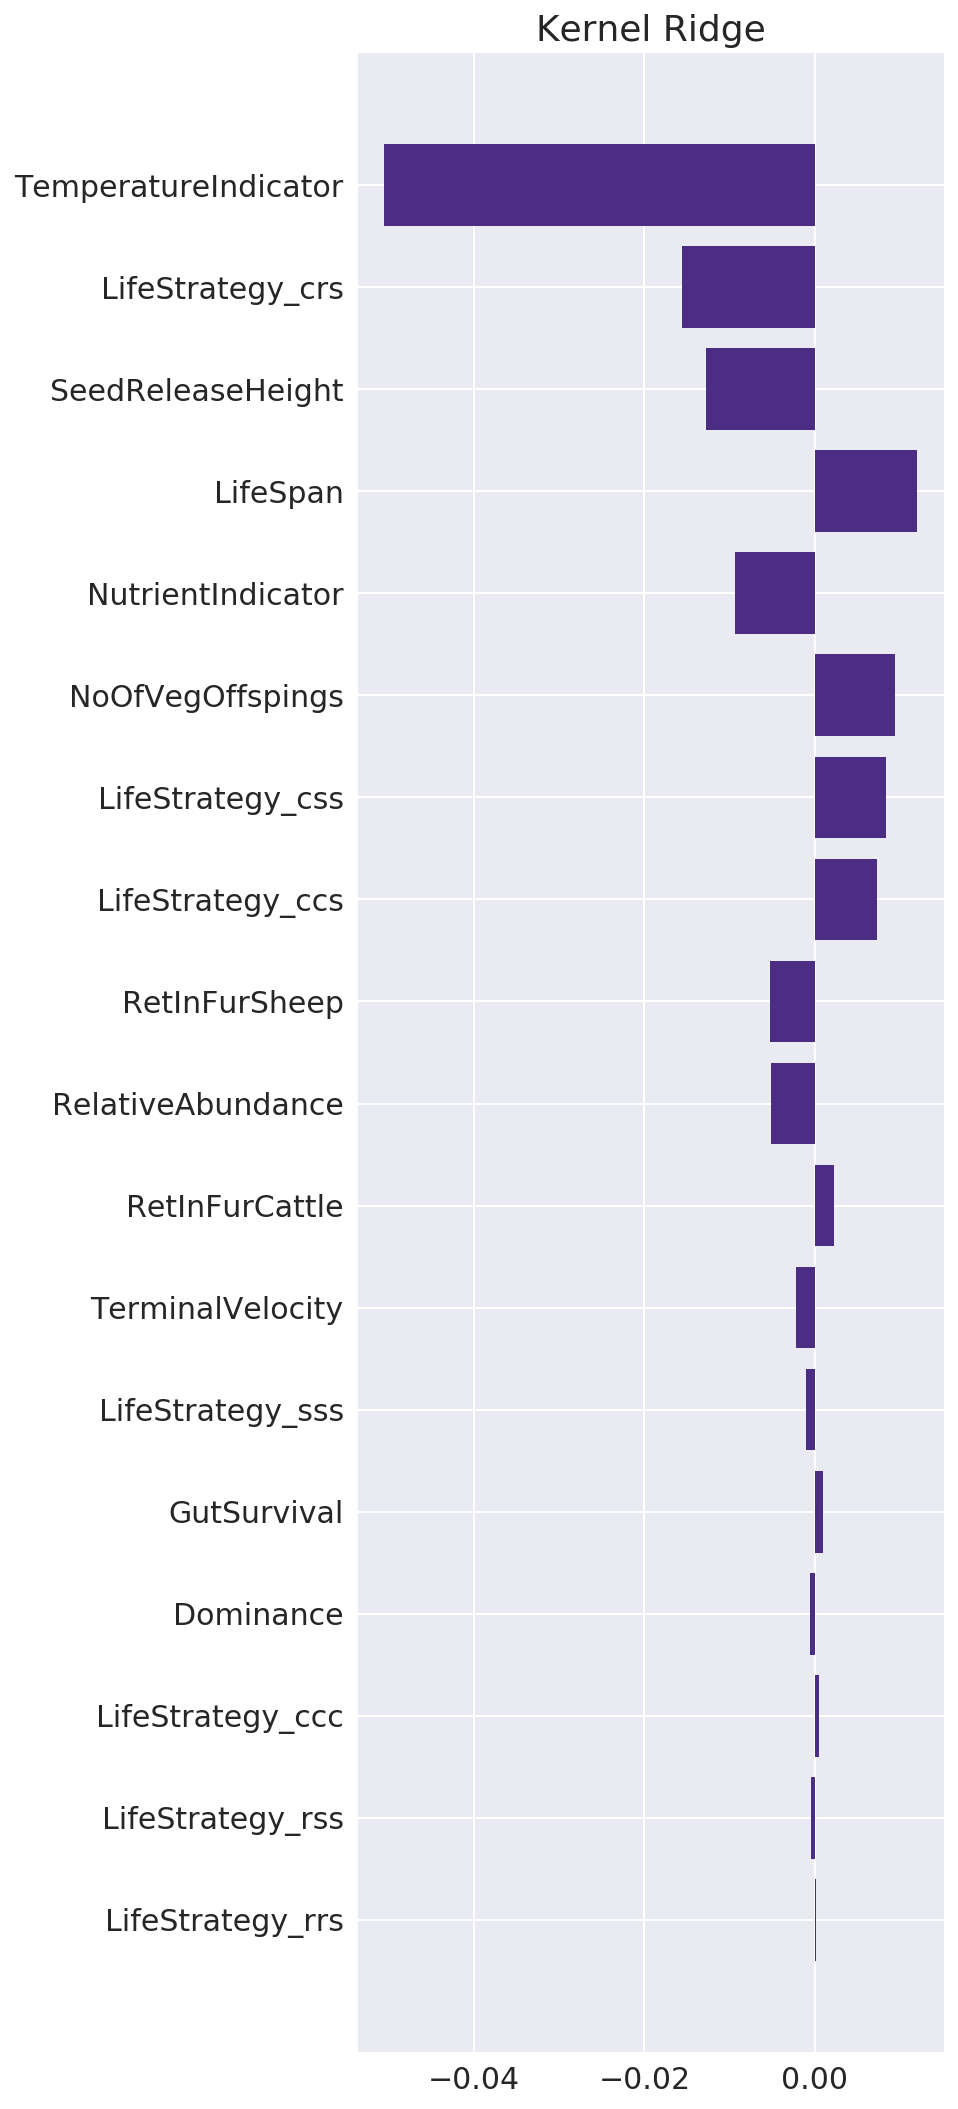

In [11]:
mean_error = np.mean(kernel_ridge_mses)
std_error = np.std(kernel_ridge_mses)
mean_coefs = np.mean(kernel_ridge_coefs, axis=0)
std_coefs = np.std(kernel_ridge_coefs, axis=0)
plot_importance(mean_coefs, td.feature_names, "Kernel Ridge", 
               save="{}_kernelridge-ranks.png".format(dsname))#, std=std_coefs)
MSEs.append(("Kernel Ridge", kernel_ridge_mses))
COEFs.append(("Kernel Ridge", mean_coefs))
rankings.append(['Kernel Ridge'] + list(compute_ranks(mean_coefs)))

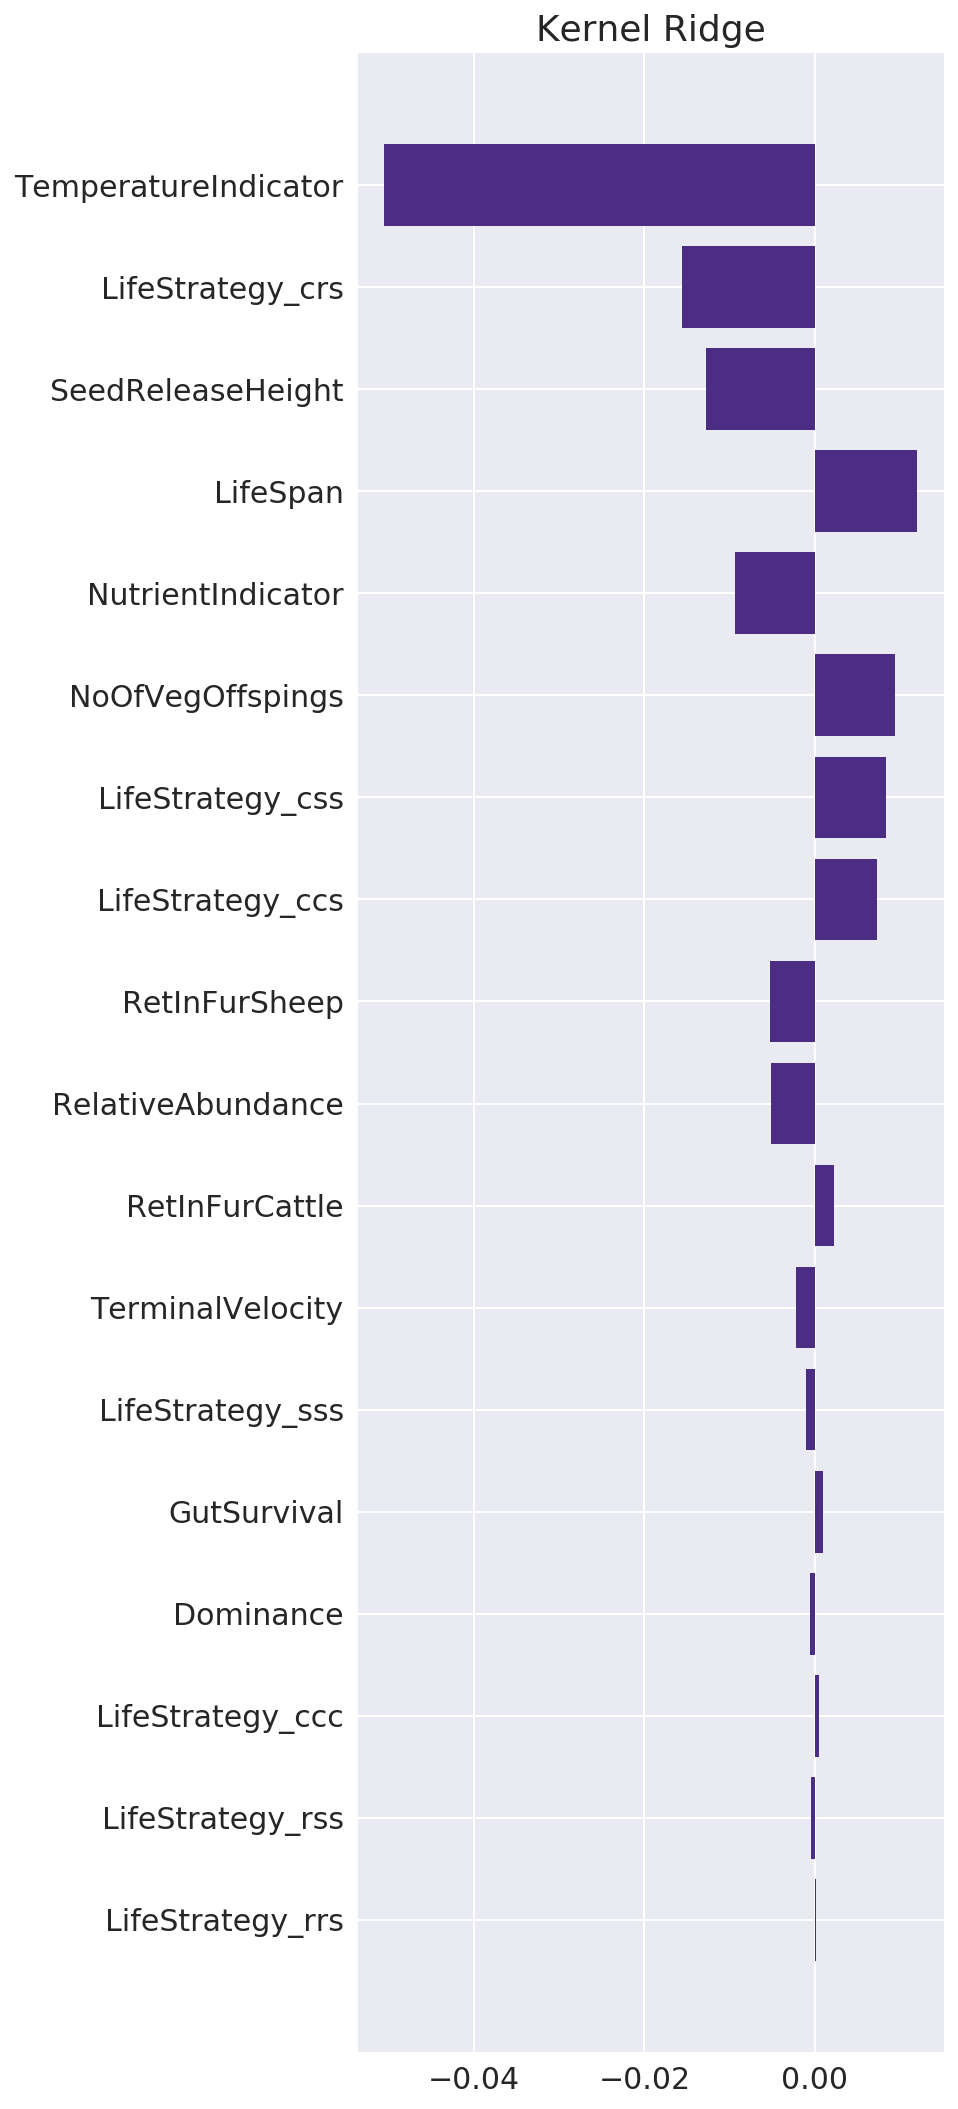

In [12]:
plot_importance(mean_coefs,
                td.feature_names,
                "Kernel Ridge", save="{}_kernelridge-nostd-ranks.png".format(dsname))
                #std=std_coefs)

rankings.append(['Kernel Ridge'] + list(compute_ranks(mean_coefs)))

### Trees

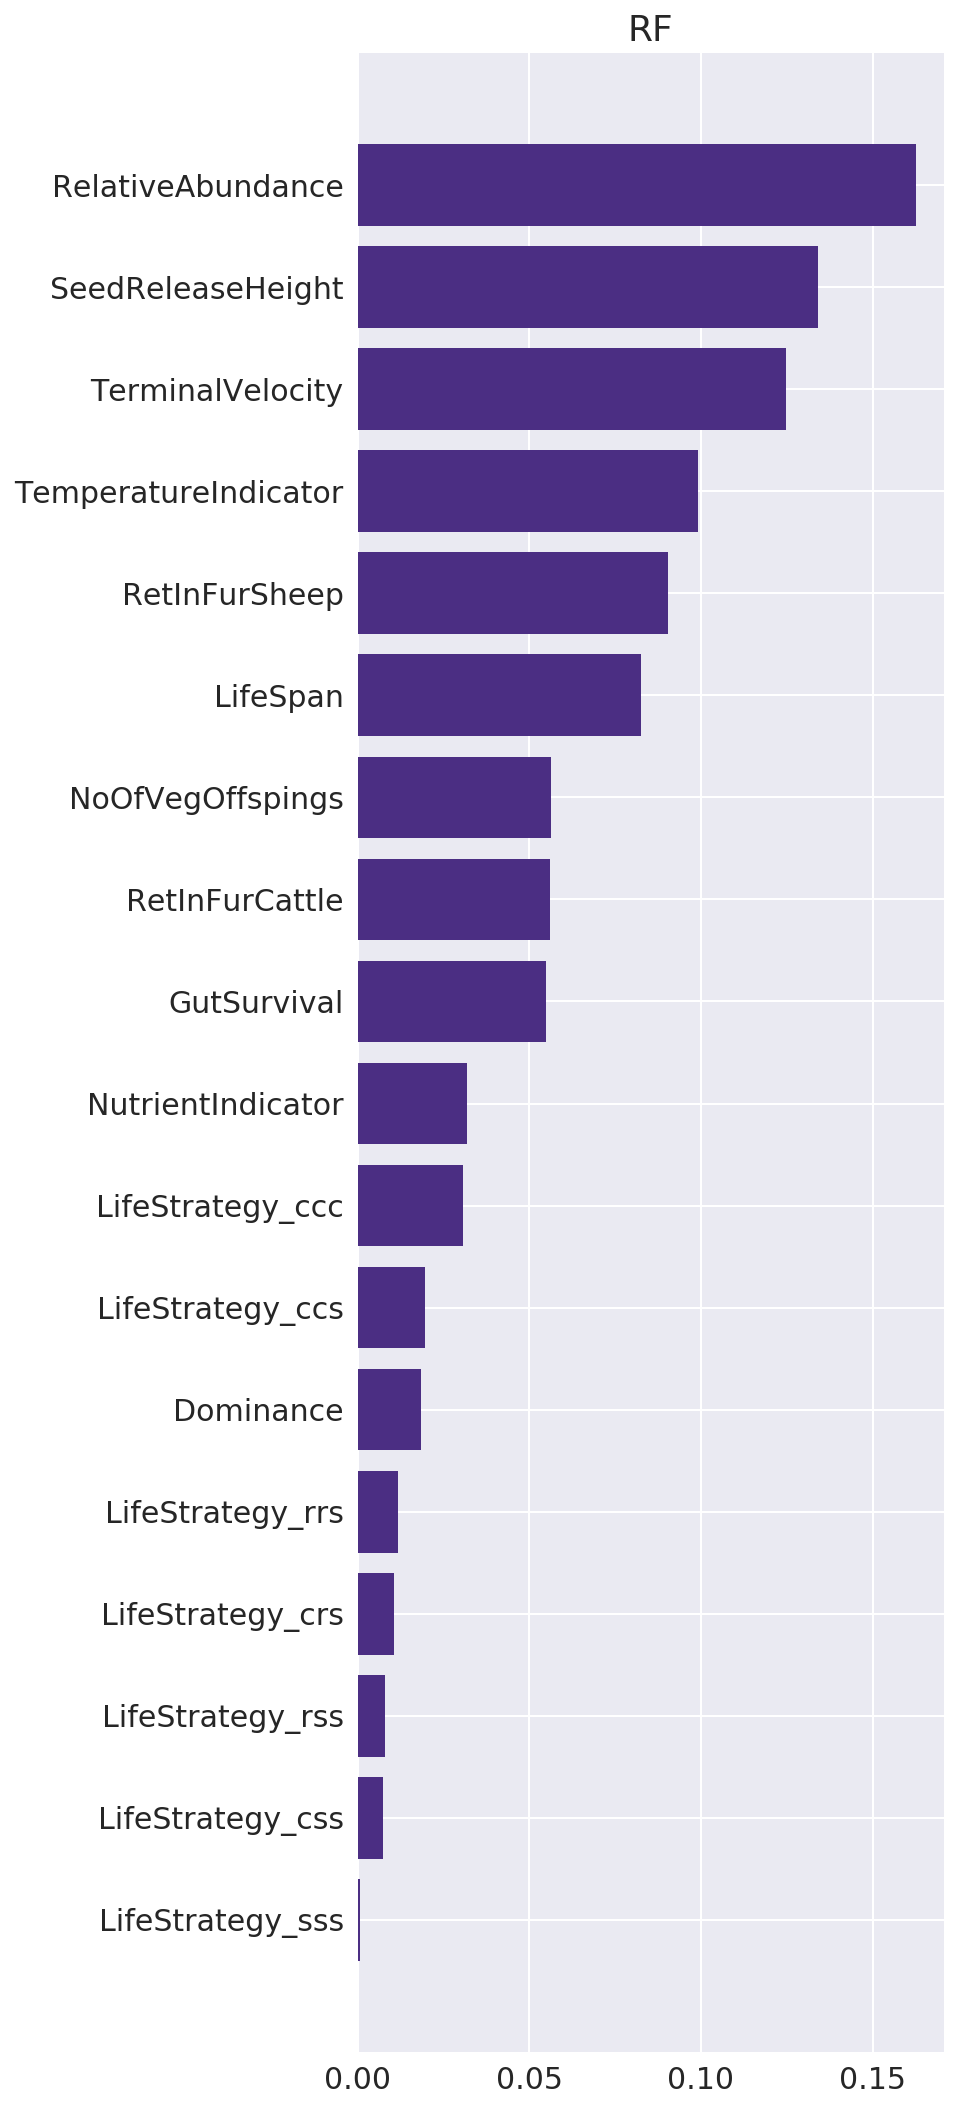

In [13]:
rf_coefs = []
rf_mses = []
for train, test in cv.split(td.X, td.Y):    
    rf = RandomForestRegressor()
    rf.fit(td.X[train], td.Y[train])
    preds = rf.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    rf_mses.append(error)
    rf_coefs.append(rf.feature_importances_)

mean_error = np.mean(rf_mses)
std_error = np.std(rf_mses)
mean_coefs = np.mean(rf_coefs, axis=0)
std_coefs = np.std(rf_coefs, axis=0)
    
MSEs.append(("RF", rf_mses))
COEFs.append(("RF", mean_coefs))
plot_importance(mean_coefs,
                td.feature_names, "RF",
                save="{}_rf-ranks.png".format(dsname))
rankings.append(['RF'] + list(compute_ranks(rf.feature_importances_)))

### Support Vectors

In [ ]:
baseModel = SVR()
params_grid = {
    'C'     : np.logspace(-3, 1.2),
    'gamma' : np.logspace(-3, 1.2),
    'degree': [0, 1, 2],
    'kernel': ['linear', 'poly', 'rbf']
}
gridSearch = GridSearchCV(baseModel,
                         param_grid = params_grid,
                         scoring="neg_mean_squared_error",
                         error_score = 0,
                         n_jobs = -1)

svr_coefs = []
svr_mses = []



for train, test in list(cv.split(td.X, td.Y)):   
    print("CV Run Init")
    gridSearch.fit(td.X[train], td.Y[train])
    best = gridSearch.best_estimator_
    preds = gridSearch.best_estimator_.predict(td.X[test])
    error = mean_squared_error(preds, td.Y[test])
    svr_mses.append(error)
    shapdata = shap.DenseData(X_train, td.feature_names)
    explainer = shap.KernelExplainer(best.predict, shapdata, nsamples=100)
    svr_coefs.append(explainer.explain(np.mat(td.X[test])).effects)


CV Run Init
CV Run Init
CV Run Init


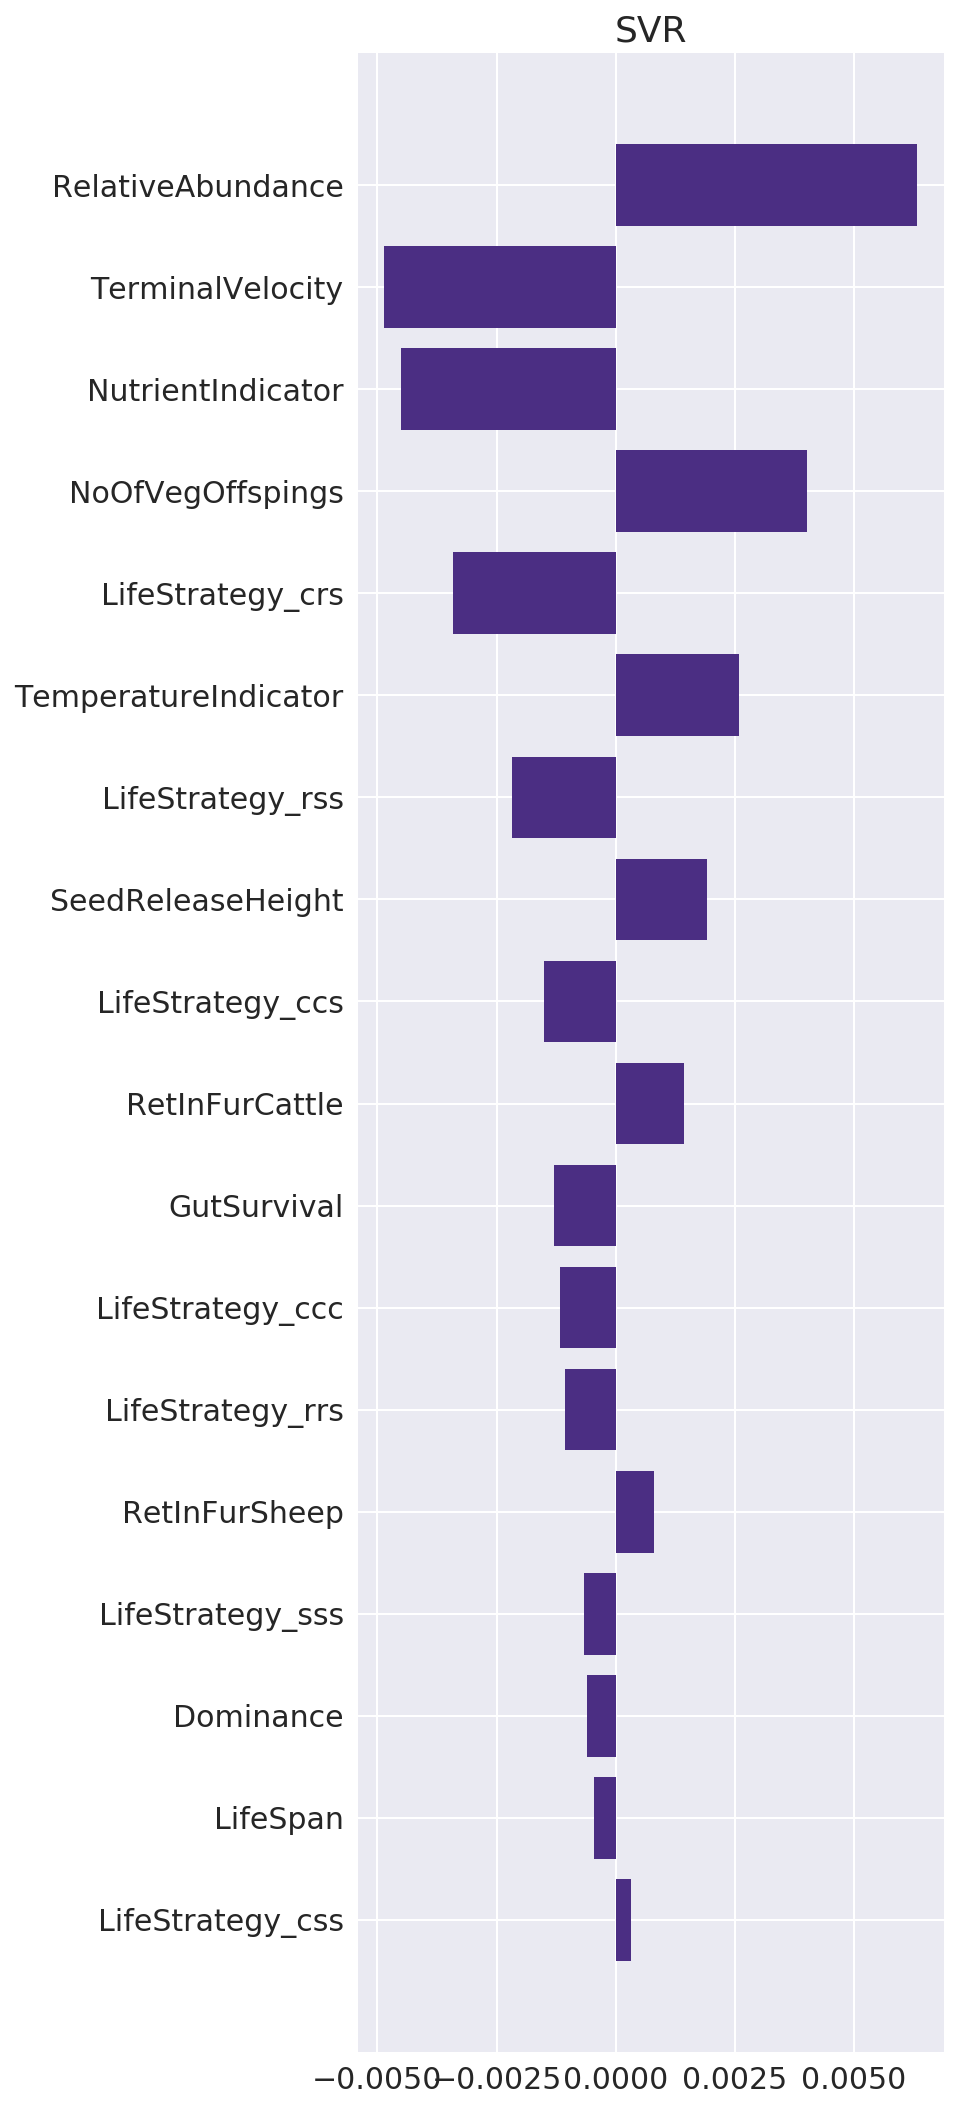

In [26]:
mean_error = np.mean(svr_mses)
std_error = np.std(svr_mses)
mean_coefs = np.mean(svr_coefs, axis=0)
std_coefs = np.std(svr_coefs, axis=0)



MSEs.append(("SVR", svr_mses))
COEFs.append(("SVR", mean_coefs))
plot_importance(mean_coefs,
                td.feature_names, "SVR",
                save="{}_svr-ranks.png".format(dsname))
rankings.append(['SVR'] + list(compute_ranks(mean_coefs)))

In [27]:
results = pd.DataFrame(rankings, columns=["Method"] + td.feature_names).set_index("Method").T
results['mean'] = results.mean(axis=1)


In [28]:
results.sort_values(by=['mean'])

Method,OLS,Ridge,Kernel Ridge,Kernel Ridge,RF,SVR,SVR,mean
TemperatureIndicator,8,4,0,0,3,5,5,3.571429
LifeStrategy_crs,3,2,1,1,15,4,4,4.285714
SeedReleaseHeight,6,7,2,2,2,7,7,4.714286
NutrientIndicator,11,8,4,4,9,2,2,5.714286
TerminalVelocity,9,6,11,11,1,1,1,5.714286
RelativeAbundance,15,9,9,9,0,0,0,6.000000
LifeStrategy_ccs,2,5,7,7,13,8,8,7.142857
NoOfVegOffspings,17,16,5,5,5,3,3,7.714286
LifeStrategy_ccc,0,0,15,15,8,11,11,8.571429
LifeSpan,12,14,3,3,4,16,16,9.714286


In [29]:
results.sort_values(by=['mean'])


Method,OLS,Ridge,Kernel Ridge,Kernel Ridge,RF,SVR,SVR,mean
TemperatureIndicator,8,4,0,0,3,5,5,3.571429
LifeStrategy_crs,3,2,1,1,15,4,4,4.285714
SeedReleaseHeight,6,7,2,2,2,7,7,4.714286
NutrientIndicator,11,8,4,4,9,2,2,5.714286
TerminalVelocity,9,6,11,11,1,1,1,5.714286
RelativeAbundance,15,9,9,9,0,0,0,6.000000
LifeStrategy_ccs,2,5,7,7,13,8,8,7.142857
NoOfVegOffspings,17,16,5,5,5,3,3,7.714286
LifeStrategy_ccc,0,0,15,15,8,11,11,8.571429
LifeSpan,12,14,3,3,4,16,16,9.714286


In [30]:
results.to_csv("{}-rank.csv".format(dsname))
from pandas.tools.plotting import table


/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.
  


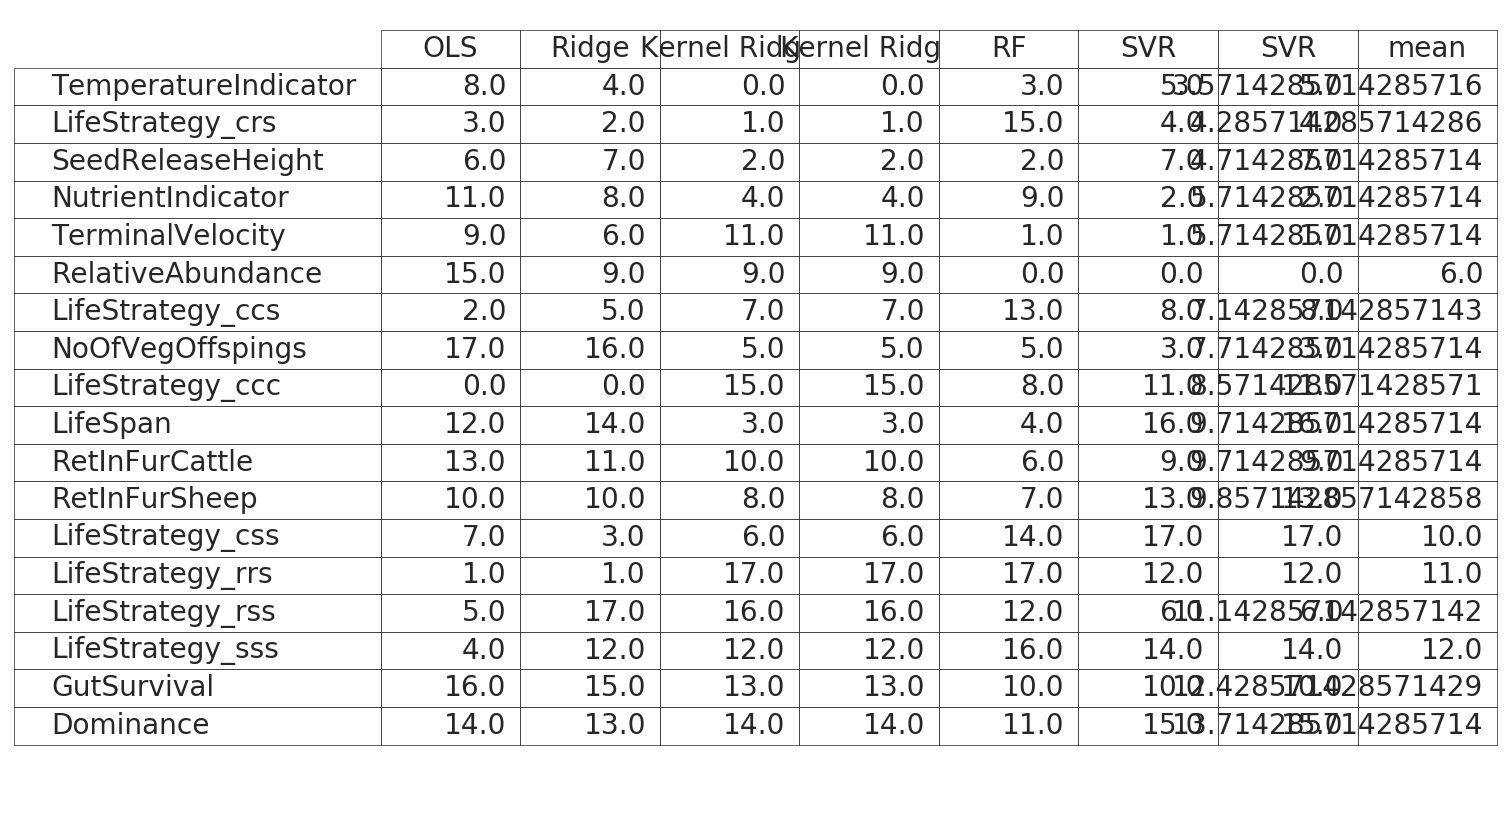

In [31]:
results = results.sort_values(by='mean')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
tab = table(ax, results, loc='upper left')
tab.auto_set_font_size(False)
tab.set_fontsize(14)
tab.scale(1.2, 1.3)
fig.tight_layout()

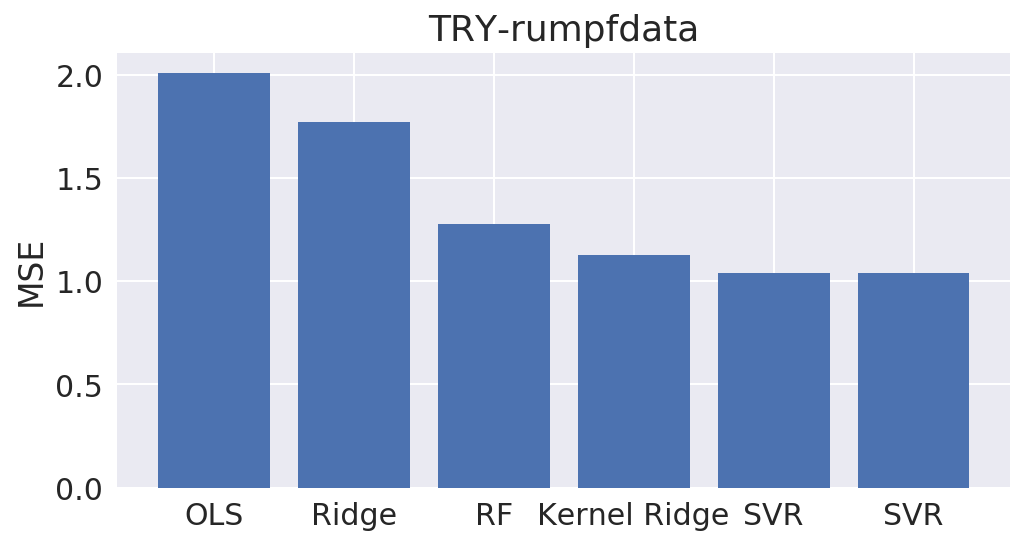

In [32]:

fig = plt.figure(figsize=(8, 4))
labels, errors = zip(*MSEs)
errors = np.array(errors)
error_means = np.mean(errors, axis=1)
error_stds = np.std(errors, axis=1)
labels = np.array(labels)
sorted_idx = np.argsort(error_means)[::-1]
plt.bar(range(0, len(MSEs)), error_means[sorted_idx])#, yerr=error_stds)
plt.xticks(range(0, len(MSEs)), labels[sorted_idx])
plt.ylabel("MSE")
plt.title(dataset['name'])
plt.savefig("{}-msecompare.png".format(dsname), dpi=200)

---
## Create Summary Plot of Coefficients
We transform our list of (method, [coefs]) pairs into a DataFrame indexed on the canonical ordering of features from the dataset. We then re-order the DataFrame using the sorted coefficients from the `results` dataframe. 

In [33]:
coefs_df = pd.DataFrame(dict(COEFs), index=td.feature_names).loc[results.index]
display(coefs_df)
coefs_df = coefs_df.iloc[::-1] # not sure why but it seems like it needs to be reversed for plotting to work right?


,Kernel Ridge,OLS,RF,Ridge,SVR
TemperatureIndicator,-0.050539,0.143525,0.099278,0.168005,0.002577
LifeStrategy_crs,-0.015535,0.245594,0.010473,0.348894,-0.003419
SeedReleaseHeight,-0.012816,0.169106,0.134235,0.107280,0.001921
NutrientIndicator,-0.009413,-0.086640,0.031953,-0.102673,-0.004514
TerminalVelocity,-0.002154,-0.140454,0.124832,-0.111362,-0.004853
RelativeAbundance,-0.005091,0.035236,0.162595,0.052165,0.006323
LifeStrategy_ccs,0.007267,-0.391518,0.019478,-0.137040,-0.001504
NoOfVegOffspings,0.009399,-0.003157,0.056301,-0.007653,0.004004
LifeStrategy_ccc,0.000507,-2.484592,0.030687,-0.995492,-0.001174
LifeSpan,0.012027,0.064939,0.082473,0.017173,-0.000456


In [34]:
def coefsSubplot(coefs, method, ax, labels=None):
    bar_indices = np.arange(len(coefs))
    
    ax.barh(bar_indices,
             coefs,
             align='center', color='#4b2e83')
    
    if labels is not None:
        ax.set_yticks(bar_indices)
        ax.set_yticklabels(labels)
    ax.set_title(method)


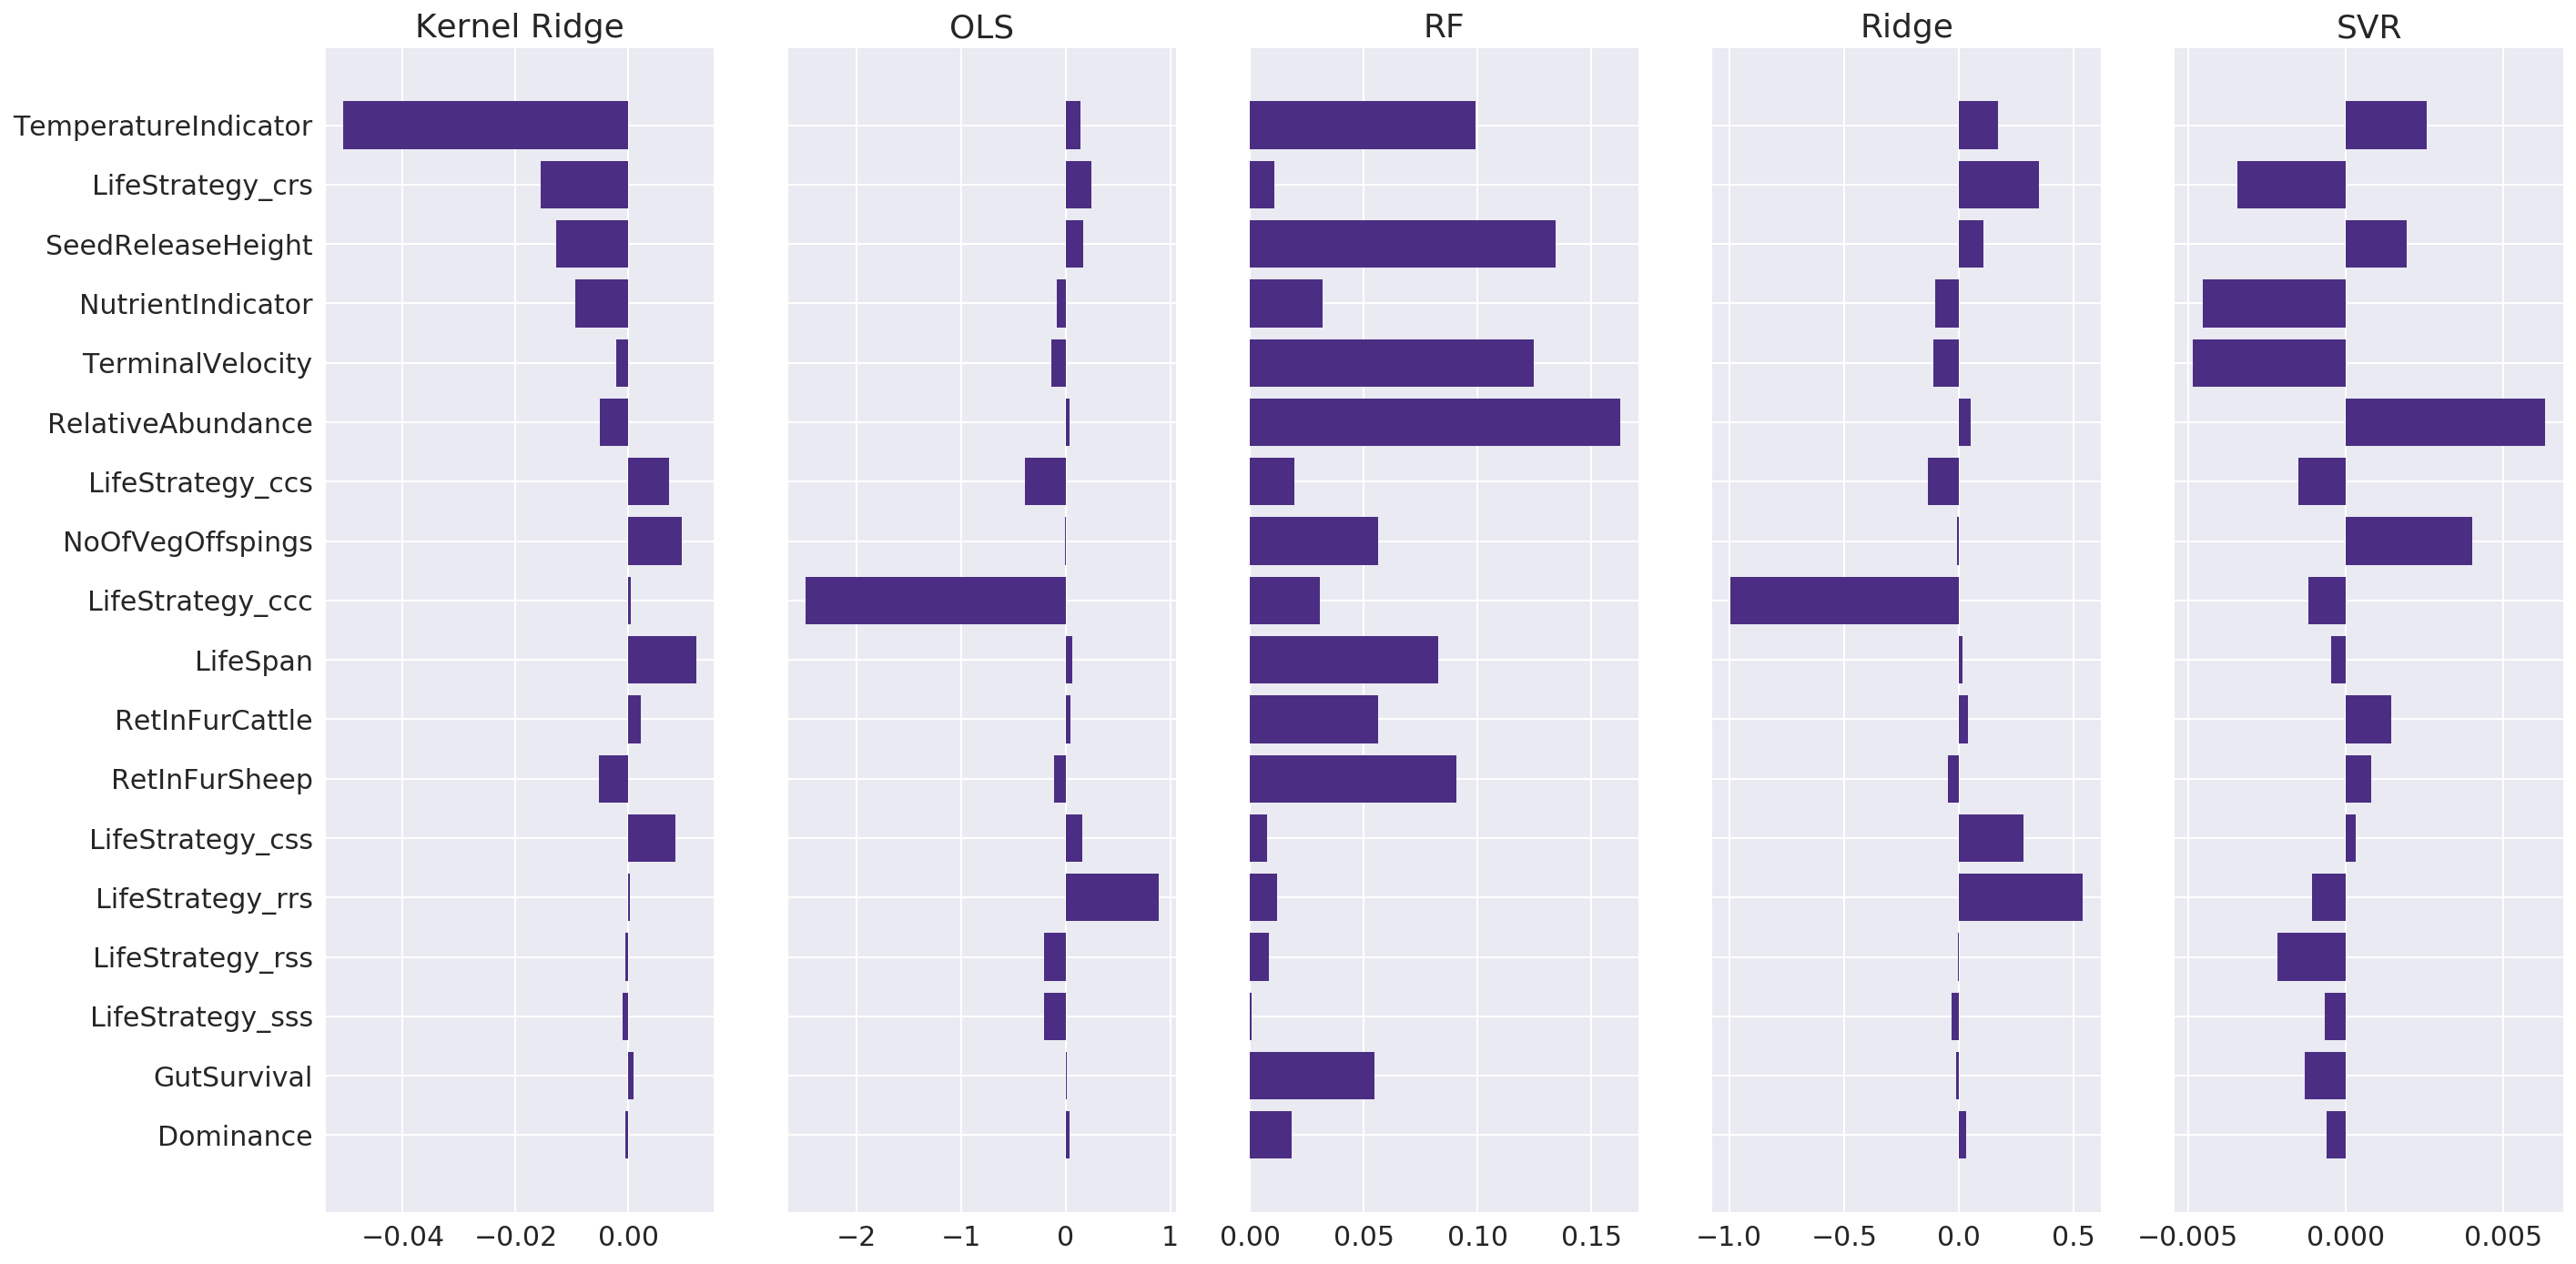

In [35]:
fig, axes = plt.subplots(nrows = 1,
                         ncols = len(coefs_df.columns), 
                         sharey = True, 
                         figsize=(20,10))
for i, c in enumerate(coefs_df.columns):
    if (i == 0):
        coefsSubplot(coefs_df[c].values, c, axes[i], labels=list(coefs_df.index))
    else: 
        coefsSubplot(coefs_df[c].values, c, axes[i], labels=None)
    
fig.tight_layout()

In [36]:
list(coefs_df.index)

['Dominance',
 'GutSurvival',
 'LifeStrategy_sss',
 'LifeStrategy_rss',
 'LifeStrategy_rrs',
 'LifeStrategy_css',
 'RetInFurSheep',
 'RetInFurCattle',
 'LifeSpan',
 'LifeStrategy_ccc',
 'NoOfVegOffspings',
 'LifeStrategy_ccs',
 'RelativeAbundance',
 'TerminalVelocity',
 'NutrientIndicator',
 'SeedReleaseHeight',
 'LifeStrategy_crs',
 'TemperatureIndicator']